<a href="https://colab.research.google.com/github/harshitash27/paralleldots-sam2-assignment/blob/main/Harshita_Paralleldots_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install core dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install hydra-core iopath pycocotools opencv-python matplotlib Pillow huggingface_hub
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# !pip install --quiet --upgrade torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 \
#     -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.8 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=16ab573d525083319fc835736c71af91f614bb8535d8a9da25f27ffd8829b8fe
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built iopath
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-g9czopxq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-g9czopxq
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.0 MB/s eta 0:0

In [ ]:
!pip install git+https://github.com/facebookresearch/sam2.git

  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-4nnc8693
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-4nnc8693
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached iopath-0.1.10-py3-none-any.whl


In [4]:
from google.colab import files
uploaded = files.upload()  # sam2_hiera_tiny.pt and sam2_hiera_t.yaml


Saving sam2.1_hiera_t.yaml to sam2.1_hiera_t.yaml
Saving sam2.1_hiera_tiny.pt to sam2.1_hiera_tiny.pt


In [5]:
from google.colab import files
uploaded = files.upload()  # choose data_2D.zip here

Saving data_2D.zip to data_2D.zip


In [6]:
import zipfile
import os

# Unzip the uploaded file
with zipfile.ZipFile('data_2D.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Set DATASET_DIR to the extracted folder
DATASET_DIR = '/content/data_2D'
print(f"DATASET_DIR set to: {DATASET_DIR}")

DATASET_DIR set to: /content/data_2D


In [7]:
# Import Libraries
import os
import cv2
import torch
import numpy as np
import pandas as pd
import json
import tempfile
import shutil
import re
import glob
import csv
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [8]:
# Import SAM2 Components

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor

In [9]:
# === Device ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [10]:
import os
from hydra import initialize_config_dir, compose
from hydra.core.global_hydra import GlobalHydra

# 1. Clear any existing Hydra state to avoid "AlreadyInitialized" errors
GlobalHydra.instance().clear()

checkpoint = "/content/sam2.1_hiera_tiny.pt"
model_cfg = "sam2.1_hiera_t.yaml"
current_dir = os.getcwd()

# 2. Use the context manager to point Hydra to your local directory
with initialize_config_dir(config_dir=current_dir, version_base=None):
    sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)

    # Initialize your predictors using the model we just built
    predictor_prompt = SAM2ImagePredictor(sam2)
    mask_generator = SAM2AutomaticMaskGenerator(sam2)

    # For the video predictor, we pass the config name again within this context
    predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device=device)

print("Model loaded successfully!")

TEMP_FOLDER = "./tempdir"

Model loaded successfully!


In [11]:
# 1. First define all required helper functions
def show_mask(mask, ax, obj_id=None, random_color=False):
    """Visualize a segmentation mask (provided in assignment)"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Default blue color
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    """Visualize input points (not used here but required)"""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size)

def show_box(box, ax):
    """Visualize bounding box (provided in assignment)"""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [12]:

def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(TEMP_FOLDER)
    cleardir(TEMP_FOLDER)
    shutil.copy(imgpath1, TEMP_FOLDER + "/00000.jpg")
    shutil.copy(imgpath2, TEMP_FOLDER + "/00001.jpg")

    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)

    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        _, out_obj_ids, out_mask_logits = predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )

    video_segments = {}

    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    if visualize:
        fig, ax = plt.subplots()
        plt.title("Original Image")
        ax.imshow(Image.open(TEMP_FOLDER + "/00000.jpg"))
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"detected object in test image ::")
        plt.imshow(Image.open(TEMP_FOLDER + "/00001.jpg"))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    return video_segments


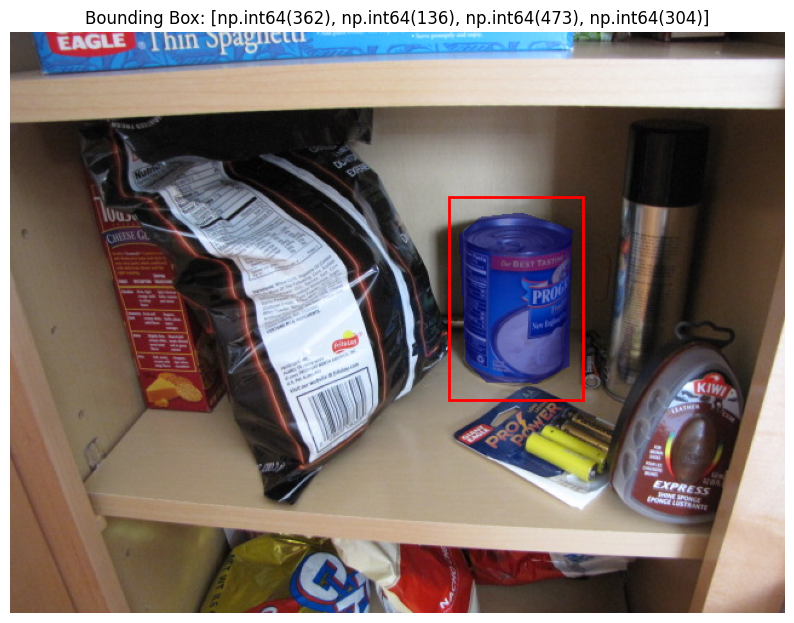

Bounding box: [np.int64(362), np.int64(136), np.int64(473), np.int64(304)]


In [13]:

def process_img_mask_pair(img_path, mask_path, visualize=True):
    """Simplified version to get bounding box from image-mask pair"""
    # Load and process images
    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path)) > 128  # Convert to binary mask

    # Get bounding box with padding
    y, x = np.where(mask)
    if not x.size:  # If mask is empty
        bbox = [0, 0, *image.shape[:2][::-1]]  # [xmin, ymin, width, height]
    else:
        padding = 0.1  # 10% padding
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        pad_x = int((xmax - xmin) * padding)
        pad_y = int((ymax - ymin) * padding)
        bbox = [
            max(0, xmin - pad_x),
            max(0, ymin - pad_y),
            min(image.shape[1], xmax + pad_x),
            min(image.shape[0], ymax + pad_y)
        ]

    # Visualization
    if visualize:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.imshow(np.ma.masked_where(~mask, mask), alpha=0.5, cmap='jet')
        plt.gca().add_patch(plt.Rectangle(
            (bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
            linewidth=2, edgecolor='r', facecolor='none'
        ))
        plt.title(f"Bounding Box: {bbox}")
        plt.axis('off')
        plt.show()

    return bbox

# Usage remains the same
bbox = process_img_mask_pair(
    "/content/data_2D/can_chowder_000001.jpg",
    "/content/data_2D/can_chowder_000001_1_gt.png"
)
print("Bounding box:", bbox)


In [14]:

def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    if os.path.exists(tempfolder):
        filepaths = glob.glob(tempfolder + "/*")
        for filepath in filepaths:
            os.unlink(filepath)
    else:
        os.mkdir(tempfolder)

In [15]:

def get_bounding_box_from_mask(mask_path):
    mask = np.array(Image.open(mask_path))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    ref_box = [x, x+w, y, y+h]
    return ref_box

def mask_to_bbox(mask):
    # Find object coordinates
    rows, cols = np.where(mask)

    if len(rows) > 0:  # Only if object detected
        xmin, xmax = min(cols), max(cols)
        ymin, ymax = min(rows), max(rows)
        ref_box = [xmin, xmax, ymin, ymax]
        return ref_box
    else:
        return [0, 0, len(mask[0]), len(mask[1])]

In [16]:
def mask_to_bbox_robust(mask):
    """
    Converts a binary mask to a bounding box [xmin, ymin, xmax, ymax].
    Improvement: Uses cv2.findContours to find the largest object.
    This filters out small pixel noise that np.where() would pick up.
    """
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    # Ensure mask is uint8 binary
    mask = (mask > 0).astype(np.uint8) * 255

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return [0.0, 0.0, 0.0, 0.0] # Empty mask

    # Find the largest contour (the actual object)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Return [xmin, ymin, xmax, ymax]
    return [float(x), float(y), float(x + w), float(y + h)]

In [17]:
def calculate_iou_coords(boxA, boxB):
    # box format: [xmin, ymin, xmax, ymax]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea if unionArea > 0 else 0


In [18]:

def discover_products(directory):
    """
    Scans the directory for .jpg files and extracts unique product names.
    Assumes naming convention: {product_name}_{6_digit_number}.jpg
    """
    products = set()
    # Regex: captures everything before the last underscore and 6 digits
    pattern = re.compile(r"(.+)_\d{6}\.jpg$")

    if not os.path.exists(directory):
        print(f"Error: Directory {directory} not found.")
        return []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            match = pattern.match(filename)
            if match:
                products.add(match.group(1))

    return sorted(list(products))


In [19]:
def visualize_comparison(img_path, gt_box, pred_box, iou, save_path=None):
    """Visualizes GT (Green) and Prediction (Red) on the same image"""
    img = Image.open(img_path)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(img)

    # Ground Truth: Green
    if sum(gt_box) > 0:
        rect_gt = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2]-gt_box[0], gt_box[3]-gt_box[1],
                                    linewidth=2, edgecolor='lime', facecolor='none', label='Ground Truth')
        ax.add_patch(rect_gt)

    # Prediction: Red
    if sum(pred_box) > 0:
        rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2]-pred_box[0], pred_box[3]-pred_box[1],
                                      linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Prediction')
        ax.add_patch(rect_pred)

    plt.legend()
    plt.title(f"IoU: {iou:.4f}")
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## **Solution for Problem statements 1 and 2**

In [20]:
# --- Main Processing Function ---
def process_and_evaluate_dataset(dataset_dir, pred_csv="predictions.csv", gt_csv="ground_truth.csv"):
    # Initialize CSVs
    csv_headers = ['filename', 'product', 'xmin', 'ymin', 'xmax', 'ymax']

    # Open both files
    #check if directory exists, if not create dir
    if not os.path.exists(os.path.dirname(pred_csv)):
        os.makedirs(os.path.dirname(pred_csv))


    file_pred = open(pred_csv, 'w', newline='')
    file_gt = open(gt_csv, 'w', newline='')

    writer_pred = csv.writer(file_pred)
    writer_gt = csv.writer(file_gt)

    # Write Headers
    writer_pred.writerow(csv_headers)
    writer_gt.writerow(csv_headers)

    products = discover_products(dataset_dir)
    print(f"Starting evaluation on {len(products)} products...")

    for product in products:
        # Setup Reference
        ref_img_path = os.path.join(dataset_dir, f"{product}_000001.jpg")
        ref_mask_path = os.path.join(dataset_dir, f"{product}_000001_1_gt.png")

        if not os.path.exists(ref_img_path): continue

        # Initial BBox
        ref_mask = np.array(Image.open(ref_mask_path))
        r_box = mask_to_bbox_robust(ref_mask)
        input_box_format = [r_box[0], r_box[2], r_box[1], r_box[3]] # [xmin, xmax, ymin, ymax] for tracker

        # Get Test Images
        test_images = sorted(glob.glob(os.path.join(dataset_dir, f"{product}_*.jpg")))
        test_images = [img for img in test_images if "000001.jpg" not in img]

        for test_img_path in test_images:
            filename = os.path.basename(test_img_path)
            gt_mask_path = test_img_path.replace(".jpg", "_1_gt.png")

            # 1. Run Tracking
            segments = track_item_boxes(ref_img_path, test_img_path, [(input_box_format, 1)], visualize=False)

            # 2. Get Prediction
            try:
                pred_mask = segments[1][1][0]
                pred_bbox = mask_to_bbox_robust(pred_mask)
            except Exception:
                pred_bbox = [0.0, 0.0, 0.0, 0.0]

            # 3. Get Ground Truth
            if os.path.exists(gt_mask_path):
                gt_mask = np.array(Image.open(gt_mask_path))
                gt_bbox = mask_to_bbox_robust(gt_mask)
            else:
                gt_bbox = [0.0, 0.0, 0.0, 0.0]

            # 4. Save to separate CSVs
            writer_pred.writerow([filename, product, *pred_bbox])
            writer_gt.writerow([filename, product, *gt_bbox])

            # 5. IoU
            iou = calculate_iou_coords(gt_bbox, pred_bbox)
            print(f"Processed {filename} | IoU: {iou:.4f}")

    file_pred.close()
    file_gt.close()
    print(f"\nDone. Saved to {pred_csv} and {gt_csv}")

# Execute
process_and_evaluate_dataset(DATASET_DIR, pred_csv="output/predictions.csv", gt_csv="output/ground_truth.csv")

Starting evaluation on 10 products...


frame loading (JPEG): 100%|██████████| 2/2 [00:00<00:00, 29.93it/s]
/usr/local/lib/python3.12/dist-packages/sam2/sam2_video_predictor.py:786: UserWarning: /usr/local/lib/python3.12/dist-packages/sam2/_C.so: undefined symbol: _ZNK3c1010TensorImpl15incref_pyobjectEv

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Processed can_chowder_000002.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


Processed can_chowder_000003.jpg | IoU: 0.9306


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Processed can_chowder_000004.jpg | IoU: 0.9010


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Processed can_chowder_000005.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Processed can_chowder_000006.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Processed can_chowder_000007.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Processed can_chowder_000008.jpg | IoU: 0.9031


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


Processed can_chowder_000009.jpg | IoU: 0.9500


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Processed can_chowder_000010.jpg | IoU: 0.9344


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


Processed can_chowder_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Processed can_chowder_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Processed can_chowder_000013.jpg | IoU: 0.9488


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Processed can_chowder_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


Processed can_chowder_000015.jpg | IoU: 0.8163


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


Processed can_chowder_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


Processed can_chowder_000017.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Processed can_chowder_000018.jpg | IoU: 0.8483


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


Processed can_chowder_000019.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Processed can_chowder_000020.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


Processed can_chowder_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


Processed can_chowder_000022.jpg | IoU: 0.9535


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Processed can_chowder_000023.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


Processed can_chowder_000024.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


Processed can_chowder_000025.jpg | IoU: 0.3799


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Processed can_chowder_000026.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


Processed can_chowder_000027.jpg | IoU: 0.7084


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Processed can_chowder_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Processed can_chowder_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


Processed can_chowder_000030.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Processed can_chowder_000031.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Processed can_chowder_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


Processed can_chowder_000033.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Processed can_chowder_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Processed can_chowder_000035.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


Processed can_chowder_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Processed can_chowder_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


Processed can_chowder_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Processed can_chowder_000039.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


Processed can_chowder_000040.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Processed can_chowder_000041.jpg | IoU: 0.5802


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Processed can_chowder_000042.jpg | IoU: 0.9787


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Processed can_chowder_000043.jpg | IoU: 0.9358


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


Processed can_chowder_000044.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


Processed can_chowder_000045.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Processed can_chowder_000046.jpg | IoU: 0.8002


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Processed can_chowder_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Processed can_chowder_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


Processed can_chowder_000049.jpg | IoU: 0.7286


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Processed can_chowder_000050.jpg | IoU: 0.8756


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Processed can_soymilk_000002.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


Processed can_soymilk_000003.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Processed can_soymilk_000004.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Processed can_soymilk_000005.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Processed can_soymilk_000006.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Processed can_soymilk_000007.jpg | IoU: 0.6869


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Processed can_soymilk_000008.jpg | IoU: 0.0787


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Processed can_soymilk_000009.jpg | IoU: 0.0239


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Processed can_soymilk_000010.jpg | IoU: 0.0848


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Processed can_soymilk_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Processed can_soymilk_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Processed can_soymilk_000013.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Processed can_soymilk_000014.jpg | IoU: 0.3374


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Processed can_soymilk_000015.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Processed can_soymilk_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Processed can_soymilk_000017.jpg | IoU: 0.0206


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Processed can_soymilk_000018.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Processed can_soymilk_000019.jpg | IoU: 0.9148


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Processed can_soymilk_000020.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Processed can_soymilk_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Processed can_soymilk_000022.jpg | IoU: 0.1181


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Processed can_soymilk_000023.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


Processed can_soymilk_000024.jpg | IoU: 0.8432


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Processed can_soymilk_000025.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Processed can_soymilk_000026.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Processed can_soymilk_000027.jpg | IoU: 0.9515


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Processed can_soymilk_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Processed can_soymilk_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


Processed can_soymilk_000030.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


Processed can_soymilk_000031.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


Processed can_soymilk_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Processed can_soymilk_000033.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Processed can_soymilk_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Processed can_soymilk_000035.jpg | IoU: 0.9674


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


Processed can_soymilk_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Processed can_soymilk_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]


Processed can_soymilk_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Processed can_soymilk_000039.jpg | IoU: 0.9245


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Processed can_soymilk_000040.jpg | IoU: 0.9399


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Processed can_soymilk_000041.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Processed can_soymilk_000042.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


Processed can_soymilk_000043.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Processed can_soymilk_000044.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Processed can_soymilk_000045.jpg | IoU: 0.9595


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Processed can_soymilk_000046.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


Processed can_soymilk_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Processed can_soymilk_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


Processed can_soymilk_000049.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Processed can_soymilk_000050.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Processed can_tomatosoup_000002.jpg | IoU: 0.9172


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Processed can_tomatosoup_000003.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


Processed can_tomatosoup_000004.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


Processed can_tomatosoup_000005.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


Processed can_tomatosoup_000006.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Processed can_tomatosoup_000007.jpg | IoU: 0.8918


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


Processed can_tomatosoup_000008.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Processed can_tomatosoup_000009.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Processed can_tomatosoup_000010.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Processed can_tomatosoup_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Processed can_tomatosoup_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]


Processed can_tomatosoup_000013.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Processed can_tomatosoup_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Processed can_tomatosoup_000015.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Processed can_tomatosoup_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]


Processed can_tomatosoup_000017.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Processed can_tomatosoup_000018.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Processed can_tomatosoup_000019.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


Processed can_tomatosoup_000020.jpg | IoU: 0.8119


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]


Processed can_tomatosoup_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Processed can_tomatosoup_000022.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


Processed can_tomatosoup_000023.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Processed can_tomatosoup_000024.jpg | IoU: 0.8602


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Processed can_tomatosoup_000025.jpg | IoU: 0.9552


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Processed can_tomatosoup_000026.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


Processed can_tomatosoup_000027.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Processed can_tomatosoup_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Processed can_tomatosoup_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Processed can_tomatosoup_000030.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Processed can_tomatosoup_000031.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


Processed can_tomatosoup_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Processed can_tomatosoup_000033.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


Processed can_tomatosoup_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Processed can_tomatosoup_000035.jpg | IoU: 0.9462


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Processed can_tomatosoup_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]


Processed can_tomatosoup_000037.jpg | IoU: 0.0124


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


Processed can_tomatosoup_000038.jpg | IoU: 0.9600


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Processed can_tomatosoup_000039.jpg | IoU: 0.9447


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


Processed can_tomatosoup_000040.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


Processed can_tomatosoup_000041.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Processed can_tomatosoup_000042.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed can_tomatosoup_000043.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


Processed can_tomatosoup_000044.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Processed can_tomatosoup_000045.jpg | IoU: 0.9401


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Processed can_tomatosoup_000046.jpg | IoU: 0.7365


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Processed can_tomatosoup_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Processed can_tomatosoup_000048.jpg | IoU: 0.8966


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed can_tomatosoup_000049.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Processed can_tomatosoup_000050.jpg | IoU: 0.9227


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Processed carton_oj_000002.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Processed carton_oj_000003.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Processed carton_oj_000004.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed carton_oj_000005.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


Processed carton_oj_000006.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Processed carton_oj_000007.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Processed carton_oj_000008.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed carton_oj_000009.jpg | IoU: 0.4759


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Processed carton_oj_000010.jpg | IoU: 0.9710


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


Processed carton_oj_000011.jpg | IoU: 0.8924


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Processed carton_oj_000012.jpg | IoU: 0.9146


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Processed carton_oj_000013.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Processed carton_oj_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


Processed carton_oj_000015.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


Processed carton_oj_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Processed carton_oj_000017.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed carton_oj_000018.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


Processed carton_oj_000019.jpg | IoU: 0.8483


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Processed carton_oj_000020.jpg | IoU: 0.8636


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Processed carton_oj_000021.jpg | IoU: 0.6182


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Processed carton_oj_000022.jpg | IoU: 0.7570


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed carton_oj_000023.jpg | IoU: 0.9234


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


Processed carton_oj_000024.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Processed carton_oj_000025.jpg | IoU: 0.7371


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Processed carton_oj_000026.jpg | IoU: 0.9781


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


Processed carton_oj_000027.jpg | IoU: 0.2661


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Processed carton_oj_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Processed carton_oj_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Processed carton_oj_000030.jpg | IoU: 0.9419


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Processed carton_oj_000031.jpg | IoU: 0.5776


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


Processed carton_oj_000032.jpg | IoU: 0.7567


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Processed carton_oj_000033.jpg | IoU: 0.7297


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]


Processed carton_oj_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


Processed carton_oj_000035.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]


Processed carton_oj_000036.jpg | IoU: 0.9028


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Processed carton_oj_000037.jpg | IoU: 0.9793


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Processed carton_oj_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Processed carton_oj_000039.jpg | IoU: 0.9019


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Processed carton_oj_000040.jpg | IoU: 0.0279


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Processed carton_oj_000041.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Processed carton_oj_000042.jpg | IoU: 0.8757


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Processed carton_oj_000043.jpg | IoU: 0.9481


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Processed carton_oj_000044.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Processed carton_oj_000045.jpg | IoU: 0.6806


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


Processed carton_oj_000046.jpg | IoU: 0.8700


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Processed carton_oj_000047.jpg | IoU: 0.6162


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


Processed carton_oj_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Processed carton_oj_000049.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed carton_oj_000050.jpg | IoU: 0.4269


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Processed carton_soymilk_000002.jpg | IoU: 0.7536


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Processed carton_soymilk_000003.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


Processed carton_soymilk_000004.jpg | IoU: 0.7308


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Processed carton_soymilk_000005.jpg | IoU: 0.6724


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Processed carton_soymilk_000006.jpg | IoU: 0.9598


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


Processed carton_soymilk_000007.jpg | IoU: 0.1575


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Processed carton_soymilk_000008.jpg | IoU: 0.6322


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Processed carton_soymilk_000009.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Processed carton_soymilk_000010.jpg | IoU: 0.1974


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Processed carton_soymilk_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed carton_soymilk_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Processed carton_soymilk_000013.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Processed carton_soymilk_000014.jpg | IoU: 0.9603


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Processed carton_soymilk_000015.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Processed carton_soymilk_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Processed carton_soymilk_000017.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


Processed carton_soymilk_000018.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Processed carton_soymilk_000019.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Processed carton_soymilk_000020.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Processed carton_soymilk_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Processed carton_soymilk_000022.jpg | IoU: 0.9498


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


Processed carton_soymilk_000023.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Processed carton_soymilk_000024.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


Processed carton_soymilk_000025.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Processed carton_soymilk_000026.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Processed carton_soymilk_000027.jpg | IoU: 0.7659


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Processed carton_soymilk_000028.jpg | IoU: 0.8135


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Processed carton_soymilk_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Processed carton_soymilk_000030.jpg | IoU: 0.0861


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


Processed carton_soymilk_000031.jpg | IoU: 0.8501


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Processed carton_soymilk_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Processed carton_soymilk_000033.jpg | IoU: 0.9129


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Processed carton_soymilk_000034.jpg | IoU: 0.5714


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


Processed carton_soymilk_000035.jpg | IoU: 0.9454


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed carton_soymilk_000036.jpg | IoU: 0.8737


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Processed carton_soymilk_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Processed carton_soymilk_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed carton_soymilk_000039.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Processed carton_soymilk_000040.jpg | IoU: 0.9287


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Processed carton_soymilk_000041.jpg | IoU: 0.8881


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Processed carton_soymilk_000042.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed carton_soymilk_000043.jpg | IoU: 0.0049


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Processed carton_soymilk_000044.jpg | IoU: 0.0082


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed carton_soymilk_000045.jpg | IoU: 0.8980


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Processed carton_soymilk_000046.jpg | IoU: 0.4060


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


Processed carton_soymilk_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Processed carton_soymilk_000048.jpg | IoU: 0.7156


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Processed carton_soymilk_000049.jpg | IoU: 0.0903


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


Processed carton_soymilk_000050.jpg | IoU: 0.3761


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed diet_coke_000002.jpg | IoU: 0.9545


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Processed diet_coke_000003.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Processed diet_coke_000004.jpg | IoU: 0.9379


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Processed diet_coke_000005.jpg | IoU: 0.8791


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Processed diet_coke_000006.jpg | IoU: 0.5822


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Processed diet_coke_000007.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Processed diet_coke_000008.jpg | IoU: 0.8752


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Processed diet_coke_000009.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed diet_coke_000010.jpg | IoU: 0.0721


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed diet_coke_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Processed diet_coke_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


Processed diet_coke_000013.jpg | IoU: 0.8577


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed diet_coke_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed diet_coke_000015.jpg | IoU: 0.0077


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed diet_coke_000016.jpg | IoU: 0.9427


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


Processed diet_coke_000017.jpg | IoU: 0.9032


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


Processed diet_coke_000018.jpg | IoU: 0.9278


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed diet_coke_000019.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Processed diet_coke_000020.jpg | IoU: 0.0293


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Processed diet_coke_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed diet_coke_000022.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed diet_coke_000023.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Processed diet_coke_000024.jpg | IoU: 0.5336


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed diet_coke_000025.jpg | IoU: 0.7182


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed diet_coke_000026.jpg | IoU: 0.9284


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed diet_coke_000027.jpg | IoU: 0.8451


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed diet_coke_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed diet_coke_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Processed diet_coke_000030.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Processed diet_coke_000031.jpg | IoU: 0.6943


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed diet_coke_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Processed diet_coke_000033.jpg | IoU: 0.5860


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Processed diet_coke_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed diet_coke_000035.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed diet_coke_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Processed diet_coke_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Processed diet_coke_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Processed diet_coke_000039.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed diet_coke_000040.jpg | IoU: 0.9103


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed diet_coke_000041.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed diet_coke_000042.jpg | IoU: 0.9450


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed diet_coke_000043.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Processed diet_coke_000044.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed diet_coke_000045.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Processed diet_coke_000046.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Processed diet_coke_000047.jpg | IoU: 0.0366


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed diet_coke_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed diet_coke_000049.jpg | IoU: 0.8772


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed diet_coke_000050.jpg | IoU: 0.0217


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed hc_potroastsoup_000002.jpg | IoU: 0.8560


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Processed hc_potroastsoup_000003.jpg | IoU: 0.8036


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed hc_potroastsoup_000004.jpg | IoU: 0.9001


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed hc_potroastsoup_000005.jpg | IoU: 0.9073


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Processed hc_potroastsoup_000006.jpg | IoU: 0.6136


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed hc_potroastsoup_000007.jpg | IoU: 0.8350


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed hc_potroastsoup_000008.jpg | IoU: 0.5047


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Processed hc_potroastsoup_000009.jpg | IoU: 0.5661


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed hc_potroastsoup_000010.jpg | IoU: 0.8705


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed hc_potroastsoup_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed hc_potroastsoup_000012.jpg | IoU: 0.8862


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed hc_potroastsoup_000013.jpg | IoU: 0.9457


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed hc_potroastsoup_000014.jpg | IoU: 0.9301


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Processed hc_potroastsoup_000015.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Processed hc_potroastsoup_000016.jpg | IoU: 0.9049


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed hc_potroastsoup_000017.jpg | IoU: 0.7791


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed hc_potroastsoup_000018.jpg | IoU: 0.7061


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed hc_potroastsoup_000019.jpg | IoU: 0.7863


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Processed hc_potroastsoup_000020.jpg | IoU: 0.9434


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Processed hc_potroastsoup_000021.jpg | IoU: 0.9352


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed hc_potroastsoup_000022.jpg | IoU: 0.7538


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


Processed hc_potroastsoup_000023.jpg | IoU: 0.5515


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Processed hc_potroastsoup_000024.jpg | IoU: 0.5562


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Processed hc_potroastsoup_000025.jpg | IoU: 0.5068


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed hc_potroastsoup_000026.jpg | IoU: 0.9099


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Processed hc_potroastsoup_000027.jpg | IoU: 0.9248


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Processed hc_potroastsoup_000028.jpg | IoU: 0.5450


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Processed hc_potroastsoup_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed hc_potroastsoup_000030.jpg | IoU: 0.0223


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Processed hc_potroastsoup_000031.jpg | IoU: 0.8968


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Processed hc_potroastsoup_000032.jpg | IoU: 0.8987


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed hc_potroastsoup_000033.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Processed hc_potroastsoup_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


Processed hc_potroastsoup_000035.jpg | IoU: 0.0731


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed hc_potroastsoup_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed hc_potroastsoup_000037.jpg | IoU: 0.8642


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Processed hc_potroastsoup_000038.jpg | IoU: 0.5764


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Processed hc_potroastsoup_000039.jpg | IoU: 0.0195


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed hc_potroastsoup_000040.jpg | IoU: 0.4613


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Processed hc_potroastsoup_000041.jpg | IoU: 0.9525


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Processed hc_potroastsoup_000042.jpg | IoU: 0.7822


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Processed hc_potroastsoup_000043.jpg | IoU: 0.8644


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed hc_potroastsoup_000044.jpg | IoU: 0.9346


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed hc_potroastsoup_000045.jpg | IoU: 0.9107


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Processed hc_potroastsoup_000046.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Processed hc_potroastsoup_000047.jpg | IoU: 0.8584


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Processed hc_potroastsoup_000048.jpg | IoU: 0.6916


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Processed hc_potroastsoup_000049.jpg | IoU: 0.8243


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed hc_potroastsoup_000050.jpg | IoU: 0.0105


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Processed juicebox_000002.jpg | IoU: 0.7110


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Processed juicebox_000003.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed juicebox_000004.jpg | IoU: 0.8215


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed juicebox_000005.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed juicebox_000006.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed juicebox_000007.jpg | IoU: 0.8997


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed juicebox_000008.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed juicebox_000009.jpg | IoU: 0.9013


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed juicebox_000010.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Processed juicebox_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed juicebox_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed juicebox_000013.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed juicebox_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed juicebox_000015.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed juicebox_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed juicebox_000017.jpg | IoU: 0.6359


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Processed juicebox_000018.jpg | IoU: 0.5094


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed juicebox_000019.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Processed juicebox_000020.jpg | IoU: 0.6061


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Processed juicebox_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed juicebox_000022.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed juicebox_000023.jpg | IoU: 0.4617


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed juicebox_000024.jpg | IoU: 0.7702


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed juicebox_000025.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed juicebox_000026.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed juicebox_000027.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed juicebox_000028.jpg | IoU: 0.9540


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed juicebox_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Processed juicebox_000030.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Processed juicebox_000031.jpg | IoU: 0.9338


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed juicebox_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Processed juicebox_000033.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Processed juicebox_000034.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed juicebox_000035.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Processed juicebox_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Processed juicebox_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed juicebox_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed juicebox_000039.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed juicebox_000040.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Processed juicebox_000041.jpg | IoU: 0.6198


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Processed juicebox_000042.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed juicebox_000043.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Processed juicebox_000044.jpg | IoU: 0.7624


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed juicebox_000045.jpg | IoU: 0.1457


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed juicebox_000046.jpg | IoU: 0.8077


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


Processed juicebox_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed juicebox_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed juicebox_000049.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed juicebox_000050.jpg | IoU: 0.6588


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Processed rice_tuscan_000002.jpg | IoU: 0.9474


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed rice_tuscan_000003.jpg | IoU: 0.9390


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed rice_tuscan_000004.jpg | IoU: 0.1154


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed rice_tuscan_000005.jpg | IoU: 0.7650


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed rice_tuscan_000006.jpg | IoU: 0.9390


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed rice_tuscan_000007.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed rice_tuscan_000008.jpg | IoU: 0.9128


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed rice_tuscan_000009.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed rice_tuscan_000010.jpg | IoU: 0.9338


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed rice_tuscan_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed rice_tuscan_000012.jpg | IoU: 0.9106


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Processed rice_tuscan_000013.jpg | IoU: 0.9155


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Processed rice_tuscan_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed rice_tuscan_000015.jpg | IoU: 0.9480


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Processed rice_tuscan_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed rice_tuscan_000017.jpg | IoU: 0.9588


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Processed rice_tuscan_000018.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed rice_tuscan_000019.jpg | IoU: 0.5666


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed rice_tuscan_000020.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Processed rice_tuscan_000021.jpg | IoU: 0.8917


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Processed rice_tuscan_000022.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Processed rice_tuscan_000023.jpg | IoU: 0.9148


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Processed rice_tuscan_000024.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed rice_tuscan_000025.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Processed rice_tuscan_000026.jpg | IoU: 0.8349


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed rice_tuscan_000027.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Processed rice_tuscan_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Processed rice_tuscan_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed rice_tuscan_000030.jpg | IoU: 0.9619


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed rice_tuscan_000031.jpg | IoU: 0.9514


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed rice_tuscan_000032.jpg | IoU: 0.9387


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed rice_tuscan_000033.jpg | IoU: 0.8435


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed rice_tuscan_000034.jpg | IoU: 0.9073


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Processed rice_tuscan_000035.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Processed rice_tuscan_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed rice_tuscan_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed rice_tuscan_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed rice_tuscan_000039.jpg | IoU: 0.8563


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


Processed rice_tuscan_000040.jpg | IoU: 0.8400


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed rice_tuscan_000041.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Processed rice_tuscan_000042.jpg | IoU: 0.6129


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Processed rice_tuscan_000043.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


Processed rice_tuscan_000044.jpg | IoU: 0.9532


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed rice_tuscan_000045.jpg | IoU: 0.9381


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed rice_tuscan_000046.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed rice_tuscan_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed rice_tuscan_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed rice_tuscan_000049.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


Processed rice_tuscan_000050.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Processed ricepilaf_000002.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Processed ricepilaf_000003.jpg | IoU: 0.9391


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed ricepilaf_000004.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed ricepilaf_000005.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed ricepilaf_000006.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Processed ricepilaf_000007.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed ricepilaf_000008.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Processed ricepilaf_000009.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed ricepilaf_000010.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed ricepilaf_000011.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Processed ricepilaf_000012.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]


Processed ricepilaf_000013.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed ricepilaf_000014.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed ricepilaf_000015.jpg | IoU: 0.2911


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Processed ricepilaf_000016.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed ricepilaf_000017.jpg | IoU: 0.8627


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Processed ricepilaf_000018.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed ricepilaf_000019.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed ricepilaf_000020.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed ricepilaf_000021.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed ricepilaf_000022.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed ricepilaf_000023.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Processed ricepilaf_000024.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed ricepilaf_000025.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Processed ricepilaf_000026.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Processed ricepilaf_000027.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Processed ricepilaf_000028.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed ricepilaf_000029.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed ricepilaf_000030.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Processed ricepilaf_000031.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed ricepilaf_000032.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Processed ricepilaf_000033.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Processed ricepilaf_000034.jpg | IoU: 0.2359


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed ricepilaf_000035.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Processed ricepilaf_000036.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Processed ricepilaf_000037.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Processed ricepilaf_000038.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s]


Processed ricepilaf_000039.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


Processed ricepilaf_000040.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Processed ricepilaf_000041.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Processed ricepilaf_000042.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Processed ricepilaf_000043.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Processed ricepilaf_000044.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Processed ricepilaf_000045.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Processed ricepilaf_000046.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Processed ricepilaf_000047.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Processed ricepilaf_000048.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Processed ricepilaf_000049.jpg | IoU: 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

Processed ricepilaf_000050.jpg | IoU: 0.0000

Done. Saved to output/predictions.csv and output/ground_truth.csv


Visualizing 5 images from CSVs...


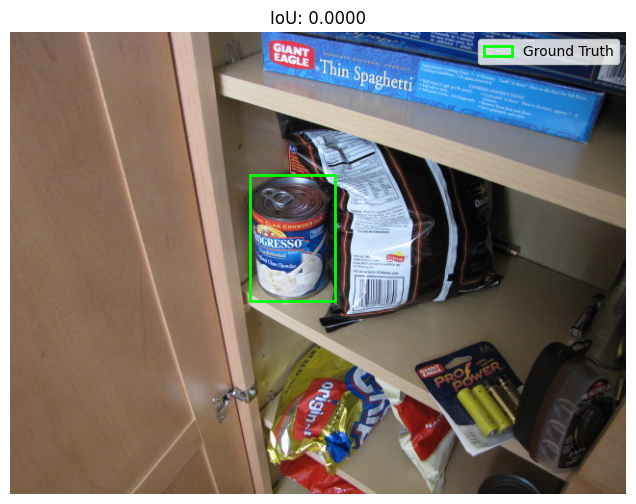

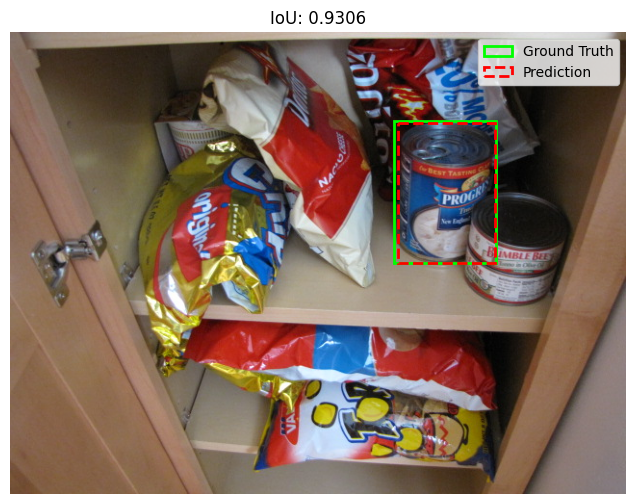

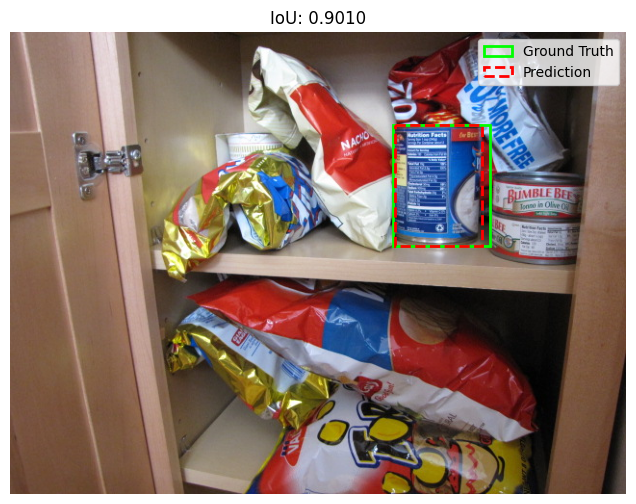

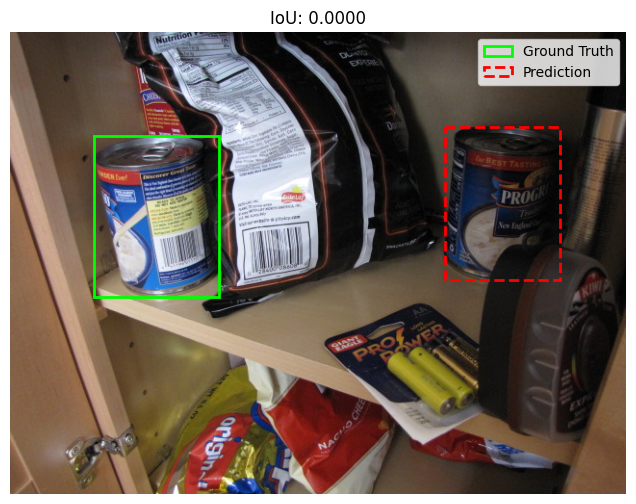

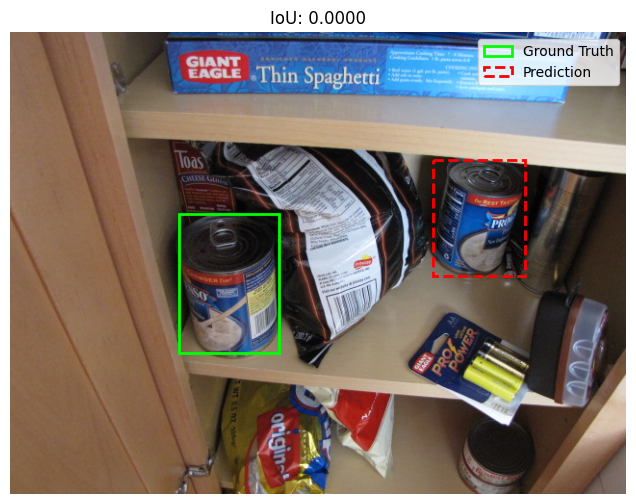

In [21]:
def visualize_from_two_csvs(pred_csv, gt_csv, dataset_dir, num_samples=None):
    if not os.path.exists(pred_csv) or not os.path.exists(gt_csv):
        print("Error: CSV files not found.")
        return

    # Load and Merge
    df_pred = pd.read_csv(pred_csv)
    df_gt = pd.read_csv(gt_csv)

    # Merge on filename (suffixes will handle name collisions for xmin/ymin etc)
    merged = pd.merge(df_gt, df_pred, on='filename', suffixes=('_gt', '_pred'))

    if num_samples:
        merged = merged.head(num_samples)

    print(f"Visualizing {len(merged)} images from CSVs...")

    for _, row in merged.iterrows():
        img_path = os.path.join(dataset_dir, row['filename'])

        if not os.path.exists(img_path): continue

        # Extract Boxes
        gt = [row['xmin_gt'], row['ymin_gt'], row['xmax_gt'], row['ymax_gt']]
        pred = [row['xmin_pred'], row['ymin_pred'], row['xmax_pred'], row['ymax_pred']]

        # Calculate IoU
        iou = calculate_iou_coords(gt, pred)

        # Plot
        visualize_comparison(img_path, gt, pred, iou)


visualize_from_two_csvs("output/predictions.csv", "output/ground_truth.csv", DATASET_DIR, num_samples=5)

In [22]:
import contextlib
import io
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## **Solution for Problem Statement 3- Performance metrics for each product**

In [23]:
import pandas as pd
import json
import os
import contextlib
import io
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate_coco_performance_with_iou(gt_csv_path, pred_csv_path):
    """
    Calculates COCO metrics + Average IoU for each product.
    """
    if not os.path.exists(gt_csv_path) or not os.path.exists(pred_csv_path):
        print("Error: CSV files not found.")
        return

    # 1. Load Data
    df_gt = pd.read_csv(gt_csv_path)
    df_pred = pd.read_csv(pred_csv_path)

    # 2. Setup Mappings
    all_filenames = set(df_gt['filename'].unique()) | set(df_pred['filename'].unique())
    img_name_to_id = {name: i for i, name in enumerate(sorted(all_filenames))}

    all_products = set(df_gt['product'].unique()) | set(df_pred['product'].unique())
    prod_name_to_id = {name: i for i, name in enumerate(sorted(all_products), 1)}

    # 3. Create COCO Ground Truth JSON
    coco_gt_data = {
        "images": [{"id": i, "file_name": n} for n, i in img_name_to_id.items()],
        "categories": [{"id": i, "name": n} for n, i in prod_name_to_id.items()],
        "annotations": []
    }

    ann_id = 1
    for _, row in df_gt.iterrows():
        w, h = row['xmax'] - row['xmin'], row['ymax'] - row['ymin']
        if w <= 0 or h <= 0: continue
        coco_gt_data['annotations'].append({
            "id": ann_id,
            "image_id": img_name_to_id[row['filename']],
            "category_id": prod_name_to_id[row['product']],
            "bbox": [row['xmin'], row['ymin'], w, h],
            "area": w * h,
            "iscrowd": 0
        })
        ann_id += 1

    # 4. Create Predictions List
    coco_results = []
    for _, row in df_pred.iterrows():
        w, h = row['xmax'] - row['xmin'], row['ymax'] - row['ymin']
        if w <= 0 or h <= 0: continue
        coco_results.append({
            "image_id": img_name_to_id[row['filename']],
            "category_id": prod_name_to_id[row['product']],
            "bbox": [row['xmin'], row['ymin'], w, h],
            "score": 1.0
        })

    # Helper function to manually calc raw IoU for the extra column
    def calculate_raw_iou_column(product_name, df_g, df_p):
        # Filter for this product
        g_prod = df_g[df_g['product'] == product_name]
        p_prod = df_p[df_p['product'] == product_name]

        # Merge on filename
        merged = pd.merge(g_prod, p_prod, on='filename', suffixes=('_gt', '_pred'))

        if merged.empty: return 0.0

        ious = []
        for _, row in merged.iterrows():
            xA = max(row['xmin_gt'], row['xmin_pred'])
            yA = max(row['ymin_gt'], row['ymin_pred'])
            xB = min(row['xmax_gt'], row['xmax_pred'])
            yB = min(row['ymax_gt'], row['ymax_pred'])

            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxAArea = (row['xmax_gt'] - row['xmin_gt']) * (row['ymax_gt'] - row['ymin_gt'])
            boxBArea = (row['xmax_pred'] - row['xmin_pred']) * (row['ymax_pred'] - row['ymin_pred'])
            unionArea = boxAArea + boxBArea - interArea

            iou = interArea / unionArea if unionArea > 0 else 0
            ious.append(iou)

        return np.mean(ious) * 100

    # 5. Initialize COCO Evaluation
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as tmp:
        json.dump(coco_gt_data, tmp)
        tmp_gt_path = tmp.name

    try:
        with contextlib.redirect_stdout(io.StringIO()):
            coco_gt = COCO(tmp_gt_path)
            if not coco_results: return
            coco_dt = coco_gt.loadRes(coco_results)

        print(f"{'PRODUCT':<30} |{'mAP (50:95)':<12}| {'AP (50)':<10} | {'AP (75)':<10} | {'Recall':<10} | {'Avg IoU':<10}")
        print("-" * 85)

        for product_name in sorted(all_products):
            # 1. Run COCO Eval
            cat_id = prod_name_to_id[product_name]
            coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
            coco_eval.params.catIds = [cat_id]

            with contextlib.redirect_stdout(io.StringIO()):
                coco_eval.evaluate()
                coco_eval.accumulate()
                coco_eval.summarize()

            # 2. Get standard metrics
            ap_mean = coco_eval.stats[0] * 100
            ap_50   = coco_eval.stats[1] * 100
            ap_75   = coco_eval.stats[2] * 100
            recall  = coco_eval.stats[8] * 100


            # 3. Get Manual Avg IoU (Direct geometric comparison)
            avg_iou = calculate_raw_iou_column(product_name, df_gt, df_pred)

            print(f"{product_name:<30} |{ap_mean:10.2f}% |{ap_50:10.2f}% |{ap_75:10.2f}% |{recall:10.2f}% |{avg_iou:10.2f}% ")

    finally:
        if os.path.exists(tmp_gt_path):
            os.remove(tmp_gt_path)

# --- Execute ---
print("\n--- Object Detection Performance ---")
evaluate_coco_performance_with_iou("output/ground_truth.csv", "output/predictions.csv")


--- Object Detection Performance ---
PRODUCT                        |mAP (50:95) | AP (50)    | AP (75)    | Recall     | Avg IoU   
-------------------------------------------------------------------------------------
can_chowder                    |     17.54% |     23.43% |     18.46% |     25.51% |     28.93% 
can_soymilk                    |      4.30% |      6.70% |      3.47% |     13.88% |     16.02% 
can_tomatosoup                 |     16.71% |     20.85% |     19.10% |     20.61% |     22.03% 
carton_oj                      |     18.53% |     31.02% |     17.31% |     32.04% |     39.76% 
carton_soymilk                 |     12.17% |     21.41% |     11.45% |     25.71% |     32.96% 
diet_coke                      |     17.49% |     27.19% |     17.46% |     25.71% |     30.75% 
hc_potroastsoup                |     38.40% |     71.65% |     41.83% |     49.18% |     61.35% 
juicebox                       |     10.55% |     21.89% |      8.29% |     16.53% |     22.85% 
rice